In [1]:
import sys
import logging, os
from time import time
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

import ipyparallel as ipp

from bem import Electrodes, Sphere, Cylinder, Mesh, Grid, Configuration, Result
from bem.formats import stl
from bem.bemColors_lib.bemColors import bemColors
from helper_functions import helper_functions

# `I. Read STL and rename electrodes` 
This part reads a colored model file `./SimpleTrap.stl`, and assigns a name for each color(thus for each electrode). The result is stored in `./SimpleTrap_mesh.vtk`.

Here we name different electrodes and refine the meshes. The size of mesh deternmines the accuracy in next step. You should set the mesh finer and finer until the result converges. Also, you can set the mesh finer and test the convergence.

## (1) color your electrodes (in fusion 360) and export stl
A trap always consists of different electrodes. Here we use different color to identify different electrodes(STL file stores color for each mesh). In fusion 360/Inventor, you can assign different appearance for different parts, of which we only cares about the color(because stl file only stores color), not texture. We recommend to use ../../bemCol_lib/bemCol.adsklib for different electrodes if you are usin Fusion 360. Same color for two electrodes means they are shorted. Then export to an stl file and move the file in the same folder as the mesh processing file. 

Below, "prefix" should be the name of the STL file. 
"a0" should be close to the characteristic distance.
"unit" is the unit for the STL file.

In [2]:
# base file name for outputs and inputs is the script name
prefix = "2D_Trap_Ba"

a0 = 70e-6    # Distance from ion to electrode is 40 µm.
unit = 1e-6   # unit of the stl file is µm.

Some notes:
* Why use standard color? We define a set of standard color lib `../../../bemCol_lib/bemCol.adsklib` for two reasons: 1. when exporting to .stl file, Fusion 360 will compress 0-256 color(RGBA32) into 0-32 color(RGBA16), which means that some similar colors in fusion 360 will become same color after export to .stl file. Our standard color lib avoid this problem. 2.If you use .stl file exported from Fusion 360 DIRECTLY, naming the electrodes would be very convinient. If you use other apps such as Inventor or Meshlab to generate .stl file, you can ignore the second reason because color encoding are quite different in different apps



## (2) The formal rename of electrode. 
### (2.1) rename directly with color code
First read stl and drop all color codes. Be sure to put something random in rename argument to drop all color codes.

In [3]:
# load electrode faces from colored stl
# s_nta is intermediate processed stl file.
s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
print("Import stl:",os.path.abspath("./"+prefix+".stl"),"\n")
print("Electrode colors (numbers):\n")
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=a0/unit,rename={1:"1"}))   
# after scale, unit is a0

Import stl: c:\Users\Photonics\Documents\GitHub\integrated_photonics_bem\Yiyang_simulation\2D_Trap_Ba.stl 

Electrode colors (numbers):

dropping 13363
dropping 20083
dropping 19943
dropping 25969
dropping 5493
dropping 13683
dropping 15905
dropping 1647
dropping 28135
dropping 7275
dropping 27949
dropping 28463
dropping 10151
dropping 19501
dropping 11517
dropping 9893
dropping 5997
dropping 5941
dropping 10095
dropping 1399
dropping 15669
dropping 15925
dropping 5345
mesh.gather() not working properly, be sure to have valid input


Assign each electrode a string name instead of its color coding. Use the numbers you get above.  
`stl.stl_to_mesh()` prints normal vectors (different faces) in each electrode.

### (2.2) rename with BemColors

Below shows how to rename electrodes with `BemColors`

The code is fully commented out, because the SimpleTrap.stl file doesn't use Fusion 360 colors. But The basic

Firstly, we print all the colors appear in the stl file. If a color is of standard colors in `bemCol.adsklib` or named manually by function `bemCol.set_my_color()`, then the color will appear in a straightforward name, such as `bem0`,`bem1` ...... . Otherwise, the color will simply be named as `'_unkCol0'` , `'_unkCol1'`, ... 


In [4]:
ele_col = bemColors(np.array(list(set(s_nta[2]))),('fusion360','export_stl'))
ele_col.set_my_color(value = (178,178,178),cl_format = ('fusion360','export_stl','RGBA64'),name = 'self_defined')
ele_col.print_stl_colors()

COLORS in the stl:
['bem6']
['bem13']
['bem19']
['bem11']
['bem17']
['bem15']
['bem1']
['bem5']
['bem12']
['bem22']
['bem18']
['bem16']
['bem3']
['bem7']
['bem9']
['bem2']
['bem4']
['bem20']
['bem10']
['bem14']
['bem8']
['bem21']
['_unkColor0']
TOTAL COLORS:  23


Next, you need to assign a name for each color appeared above. With standard colors defined in `bemCol.adsklib`, the correspondence between color and electrode is clear, which make it easy for this step. You can also comment out some `ele_col.set_color_name()`, run all the codes again and observe the missing part in the printed figure, which corresponds to the electrode you comment out. The second method also serves as a double check. Besides, parameter in `stl.stl_to_mesh()` can be set as `quiet = False` to check whether the program reads planes correctly.

In [5]:
# # assign a name for each color
ele_col.color_electrode(color = 'bem1',name = 'GND')
ele_col.color_electrode(color = 'bem2',name = 'DC1')
ele_col.color_electrode(color = 'bem3',name = 'DC2')
ele_col.color_electrode(color = 'bem4',name = 'DC3')
ele_col.color_electrode(color = 'bem5',name = 'DC4')
ele_col.color_electrode(color = 'bem6',name = 'DC5')
ele_col.color_electrode(color = 'bem7',name = 'DC6')
ele_col.color_electrode(color = 'bem8',name = 'DC7')
ele_col.color_electrode(color = 'bem9',name = 'DC8')
ele_col.color_electrode(color = 'bem10',name = 'DC9')
ele_col.color_electrode(color = 'bem11',name = 'DC10')
ele_col.color_electrode(color = 'bem12',name = 'RF')
ele_col.color_electrode(color = 'bem13',name = 'DC11')
ele_col.color_electrode(color = 'bem14',name = 'DC12')
ele_col.color_electrode(color = 'bem15',name = 'DC13')
ele_col.color_electrode(color = 'bem16',name = 'DC14')
ele_col.color_electrode(color = 'bem17',name = 'DC15')
ele_col.color_electrode(color = 'bem18',name = 'DC16')
ele_col.color_electrode(color = 'bem19',name = 'DC17')
ele_col.color_electrode(color = 'bem20',name = 'DC18')
ele_col.color_electrode(color = 'bem21',name = 'DC19')
ele_col.color_electrode(color = 'bem22',name = 'DC20')

# # print colors still with no name. These meshes will be neglected in the following codes
ele_col.drop_colors()

# # read stl into mesh with electrode names
# # unnamed meshes will not be imported at all
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=a0/unit,
    rename=ele_col.electrode_colors, quiet=True))

dropping color ['_unkColor0']
TOTAL COLORS DROPPED:  1
dropping 20083


# `II. Remesh with constraint` 

In this step, we generate triangle mesh with constraints. The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library. Folowing variables are all in unit `mesh_unit` now.

Our remesh strategy consists of two steps of triangulation: 
1. global triangulation without constraint. This step eliminate some long and sharp triangles by combining and dividing, and obtains a coarse grain triangulated model.
2. local triangulation with constraint. This step refines each triangles in step 1, the triangle density is defined by `mesh.areas_from_constraints`

It is better to update triangle density gradually to accurately position the constraint boundary. Parameters in the below code block should be tuned specificly for different trap geometries.

Notes:
- mesh.triangulate function takes in a parameter opts, after some processing of the wrap function, opts changes a little and prints as final opts. These final opts finally passes into Fastlap triangulate package, of which parameters and usage can be found in this link (http://www.cs.cmu.edu/~quake/triangle.switch.html).

In [6]:
# 1. Global triangulation
mesh.triangulate(opts="q20Q",new = False)

# 2. Local triangulation
# areas_from_constraints specifies sphere/cylinder with finer mesh inside it.
# "inside", "outside" set different mesh densities.

# # first refine
mesh.areas_from_constraints(Sphere(center=np.array([(5000-300)/(a0*1e6), 0, 0]), radius=10, inside=0.25, outside=5))    # Sphere constraint
# mesh.areas_from_constraints(Cylinder(start = np.array([-1, 0, 0]), end = np.array([1, 0, 0]), radius = 2, inside=2, outside=10)) # Cyliner constraint
mesh.triangulate(opts="q20Q", new=False) # retriangulate quality and quiet with areas

# second refine
mesh.areas_from_constraints(Sphere(center=np.array([(5000-300)/(a0*1e6), 0, 0]), radius=10, inside=0.25, outside=5))    # Sphere constraint
# mesh.areas_from_constraints(Cylinder(start = np.array([-1, 0, 0]), end = np.array([1, 0, 0]), radius = 2, inside=0.2, outside=10)) # Cyliner constraint
# mesh.triangulate(opts="q20Q", new=False) # retriangulate quality and quiet with areas

# # first refine
# mesh.areas_from_constraints(Sphere(center=np.array([5000/(a0*1e6), 0, 0]), radius=10, inside=1.*0.1, outside=2)); # Sphere constraint
# mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas

# # second refine
# mesh.areas_from_constraints(Sphere(center=np.array([5000/(a0*1e6), 0, 0]), radius=10, inside=0.1*0.1, outside=20)); # Sphere constraint
# mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas


# 3. save base mesh to vtk
mesh.to_vtk(prefix)
print("Output vtk:",os.path.abspath("./"+prefix+".vtk"))    # output path

start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12
final opts q20Qzr
finish triangulate DC12
start triangulate DC9
final opts q20Qzr
finish triangulate DC9
start triangulate DC5
final opts q20Qzr
finish triangulate DC5
start triangulate DC1
final opts q20Qzr
finish triangulate DC1
start triangulate DC2
final opts q20Qzr
finish triangulate DC2
start triangulate DC6
final opts q20Qzr
finish triangulate DC6
start triangulate DC10
final opts q20Qzr
finish triangulate DC10
start triangulate DC13
final opts q20Qzr
finish triangulate DC13
start triangulate DC17
final opts q20Qzr
finish triangulate DC17
start triangulate DC15
final opts q20Qzr
finish triangulate DC15
start triangulate DC19
final opts q20Qzr
finish triangulate DC19
start triangulate DC11
final opts q20Qzr
finish triangulate DC11
start triangulate D

## Visualize in 3D to check mesh
Can be used to check whether electrode faces are colored properly, and whether electrodes are named properly.

Plot mesh using pyvista plotter in a separate window.
On macOS perhaps Linux as well, the window doesn't close properly after clicking close button, but the code can continue to run.

In [7]:
# Plot triangle meshes.
mesh.plot()

# `III. Main boundary element calculations`
## (1) Define job function

In `run_job` function, `job` is `Configuration` instance and `grid` is discretirized spatial grid (not the mesh). The general workflow (also the routine of BEM method) are:  
1. `solve_singularities()` solves charge distributions by iterative methods to make it consistent with one electrode at 1V and others at 0V (unit potentials). `adapt_mesh()` refines meshes adaptively to achieve certain precision while solving sigulartities.
2. Compute potentials on given grid points by `simulate()`, based on the charge distributions gotten previously.
3. Potential data of each unit potential are saved seperately to a `Result` instance, and also export to VTK files.
4. Return total accumulated charge per electrode in the end.

Major calculations calls `fastlap` C library which uses a pre-conditioned, adaptive, multipole-accelerated algorithm for solving Laplace problem. Two parameters control multipole acceleration.
+ num_mom, the number of multipole
+ num_lev, the number of levels in the hierarchical spatial decomposition.  
num_lev=1 means direct computation without multipole acceleration. See fastlap ug.pdf and README.rst.

In [8]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min angle 25 deg.
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for surface charges
    job.solve_singularities(num_mom=4, num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=2)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

## (2) Define grid

Create a grid in unit of scaled length `l`. Only choose the interested region (trap center) to save time.

In [9]:
# in um
gap_top = -7.929;
middle_electrode = -77;
distance_ref1 = (5000-300);
distance_ref2 = 4496;

#define the physical distance I want to simulate, in um
Lx_phy = 100;
Ly_phy = 100;
Lz_phy = 100;

#define the physical step size I want, in um
sx_phy = 1;
sy_phy = 1;
sz_phy = 1;

#center
center_x = distance_ref1/(a0*1e6);
center_y = (gap_top+middle_electrode/2)/(a0*1e6);

# grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
Lx, Ly, Lz = Lx_phy / (a0*1e6), Ly_phy / (a0*1e6), Lz_phy / (a0*1e6)    # in the unit of scaled length l
sx, sy, sz = sx_phy / (a0*1e6), sy_phy / (a0*1e6), sz_phy / (a0*1e6)
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/ss).astype('int')+1 for ss, L in zip((sx, sy, sz), (Lx, Ly, Lz))]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(0, center_y, 75/(a0*1e6)), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin()[0])

Size/l: 1.4285714285714286 1.4285714285714286 1.4285714285714286
Step/l: 0.014285714285714285 0.014285714285714285 0.014285714285714285
Shape (grid point numbers): 101 101 101
Grid origin/l: -0.7142857142857143


## (3) Parallel computation using ipyparallel, which is compatible with Savio BRC-HPC

In [ ]:
# create job list

# electrode_names = ['DC1','DC2','DC3','DC4','DC5','DC6','DC7','DC8','DC9','DC10',
#                    'DC11','DC12','DC13','DC14','DC15','DC16','DC17','DC18','DC19','DC20' ];

electrode_names = 'DC1';

jobs = list(Configuration.select(mesh, electrode_names))
# evaluate electric potential for each configurations: one electrode at 1V, the rest 0V.

# parallel computation
mycluster = ipp.Cluster()
mycluster.start_cluster_sync()
c = mycluster.connect_client_sync()
c.wait_for_engines()

t0 = time()
# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
asyncresult = lview.map_async(run_job, ((job, grid, prefix) for job in jobs))   # Run calculation in parallel
asyncresult.wait_interactive()
print("Computing time: %f s"%(time()-t0))
c.shutdown(hub=True);

Starting 32 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/32 [00:00<?, ?engine/s]

run_job:   0%|          | 0/11 [00:00<?, ?tasks/s]

Computing time: 1108.614833 s
engine set stopped 1741220135: {'engines': {'2': {'exit_code': 0, 'pid': 18900, 'identifier': '2'}, '29': {'exit_code': 0, 'pid': 29084, 'identifier': '29'}, '26': {'exit_code': 0, 'pid': 28788, 'identifier': '26'}, '15': {'exit_code': 0, 'pid': 19392, 'identifier': '15'}, '6': {'exit_code': 0, 'pid': 15152, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 9416, 'identifier': '1'}, '17': {'exit_code': 0, 'pid': 27412, 'identifier': '17'}, '0': {'exit_code': 0, 'pid': 16064, 'identifier': '0'}, '28': {'exit_code': 0, 'pid': 29020, 'identifier': '28'}, '27': {'exit_code': 0, 'pid': 28912, 'identifier': '27'}, '25': {'exit_code': 0, 'pid': 28724, 'identifier': '25'}, '16': {'exit_code': 0, 'pid': 25144, 'identifier': '16'}, '3': {'exit_code': 0, 'pid': 10512, 'identifier': '3'}, '20': {'exit_code': 0, 'pid': 27616, 'identifier': '20'}, '10': {'exit_code': 0, 'pid': 9148, 'identifier': '10'}, '11': {'exit_code': 0, 'pid': 13352, 'identifier': '11'}, '5': {'exi

## (4) View result in 3D

This part can be done in other files as well. You only need to define prefix and make sure the two result files for each electrode, i.e. ```<prefix>_<electrode_name>.vtk``` and ```<prefix>_<electrode_name>_mesh.vtk```, are in the same directory as the code. Also don't remember to put the base mesh ```<prefix>_mesh.vtk``` in the same folder.

Result view inlcudes charge distribution, potential/field_square contours.

In [13]:
# base file name for outputs and inputs is the script name
prefix = "2D_Trap_Ba"

view exported base mesh vtk file

In [14]:
Result.view(prefix, '') # don't add anything between '' for mesh view

view simulation result of an electrode

In [15]:
Result.view(prefix, 'RF') # add electrode name between '' for result view

# `IV. Load result for analysis`

All analysis are intended to be done outside of the simulation file. Here shows how to access the simulated data, such as potential (DC and RF), field (RF only), field square (RF only), for each electrode.

In [16]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams["font.family"] = "Times"

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:
rf_result = Result.from_vtk(prefix, 'RF')
grid = rf_result.grid.to_xyz() # access the (x, y, z) coordinates
potential =rf_result.potential # access the simulated potential data
field = rf_result.field # access the simulated field data
field_square = rf_result.field_square # access the simulated field_square data

stable height is 76.999923 um
stable displacement is 3.0 um towards the shorter RF electrode


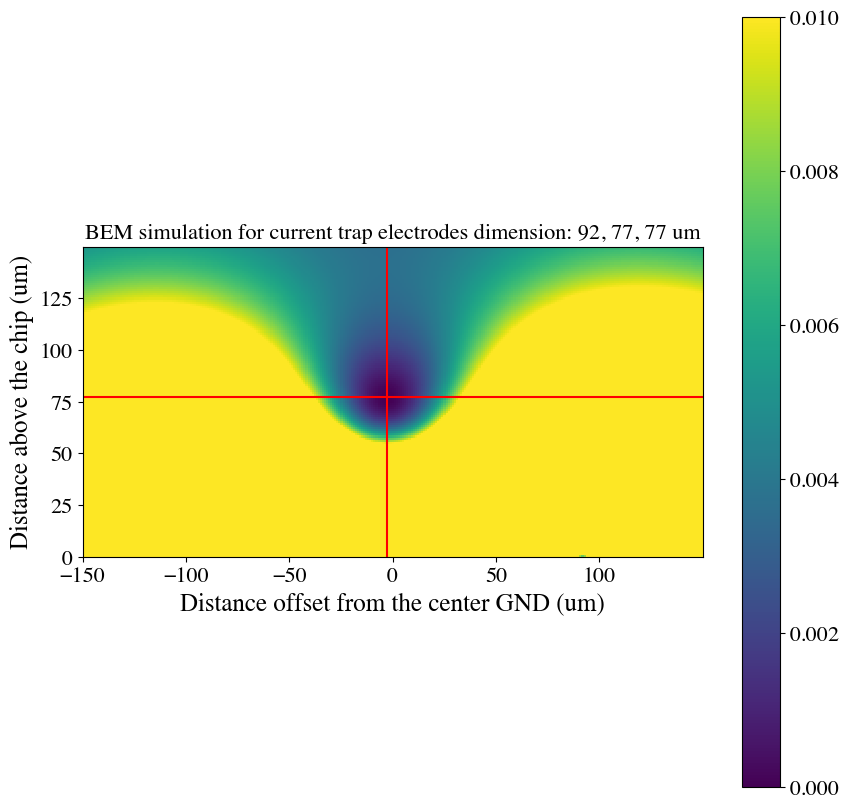

In [19]:
%matplotlib inline

plt.figure(figsize=(10, 10))  # width, height in inches
plt.imshow(field_square[0,:,:].transpose() ,extent=[grid[1][0]*a0*1e6 + (((0+7.929) + 77/2)), grid[1][-1]*a0*1e6 + (((0+7.929) + 77/2)), grid[2][0]*a0*1e6, grid[2][-1]*a0*1e6], origin='lower', cmap='viridis', interpolation = 'nearest', vmin=0,vmax=0.01)
plt.colorbar()
plt.ylabel('Distance above the chip (um)');
plt.xlabel('Distance offset from the center GND (um)');
plt.title('BEM simulation for current trap electrodes dimension: 92, 77, 77 um');


out = np.where(field_square == field_square[:-2, 2:-2].min());
select = 2;
z0 = grid[select][out[select][0]]*a0*1e6;
plt.axhline(z0, c='red');
select = 1;
y0= grid[select][out[select][0]]*a0*1e6 + 77/2 + 7.929
plt.axvline(y0, c='red');

print(f'stable height is {z0} um');
print(f'stable displacement is {np.round(-y0,3)} um towards the shorter RF electrode');

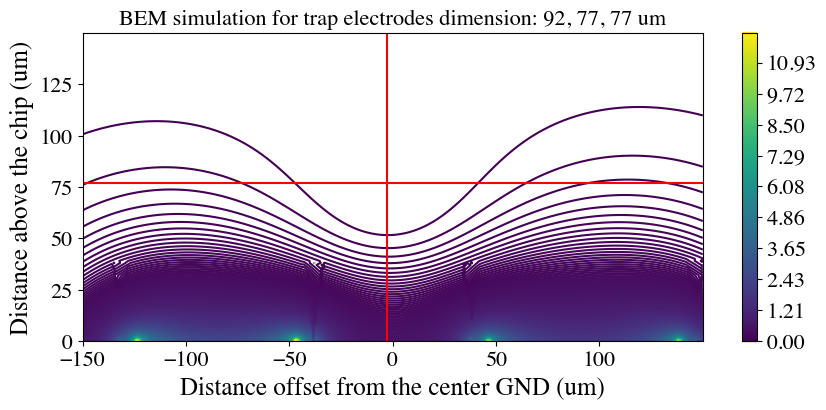

In [20]:
[Y, Z] = np.meshgrid(grid[1]*a0*1e6 + 77/2 + 7.929, grid[2]*a0*1e6);

plt.figure(figsize=(10,4))
CS = plt.contour(Y,Z, field_square[0,:,:].transpose(), levels = 1000);
plt.colorbar()
plt.ylabel('Distance above the chip (um)');
plt.xlabel('Distance offset from the center GND (um)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');
out = np.where(field_square == field_square[:-2, 2:-2].min());
select = 2;
z0 = grid[select][out[select][0]]*a0*1e6;
plt.axhline(z0, c='red');
select = 1;
y0= grid[select][out[select][0]]*a0*1e6 + 77/2 + 7.929
plt.axvline(y0, c='red');

In [16]:
# mesh visual
mesh_factor = np.array([4, 0.1]);
# mesh_factor = np.linspace(0.2, 0.0, 8);


for i in range(len(mesh_factor)):

    del mesh;

    #just create a new mesh every time
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=a0/unit, rename=ele_col.electrode_colors, quiet=True))

    #here is the location that will be the reference point for further meshing
    #usually, this is the ion's location, specified in a0 unit
    zl = 1;
    yl = (-7.929 - 77/2)/(a0*1e6);
    xl = 50;
    rad = 10;
    
    # 1. Global triangulation
    mesh.triangulate(opts="q20Q",new = False);
    
    # 2. Local triangulation
    # areas_from_constraints specifies sphere/cylinder with finer mesh inside it.
    # "inside", "outside" set different mesh densities.
    
    # first refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=1.*mesh_factor[i], outside=2)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas

    # second refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=0.1*mesh_factor[i], outside=20)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas
    
    # 3. save base mesh to vtk
    mesh.to_vtk(prefix)
    print("Output vtk:",os.path.abspath("./"+prefix+".vtk"))    # output path
    mesh.plot();



dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12
final opts q20Qzr
finish triangulate DC12
start triangulate DC9
final opts q20Qzr
finish triangulate DC9
start triangulate DC5
final opts q20Qzr
finish triangulate DC5
start triangulate DC1
final opts q20Qzr
finish triangulate DC1
start triangulate DC2
final opts q20Qzr
finish triangulate DC2
start triangulate DC6
final opts q20Qzr
finish triangulate DC6
start triangulate DC10
final opts q20Qzr
finish triangulate DC10
start triangulate DC13
final opts q20Qzr
finish triangulate DC13
start triangulate DC17
final opts q20Qzr
finish triangulate DC17
start triangulate DC15
final opts q20Qzr
finish triangulate DC15
start triangulate DC19
final opts q20Qzr
finish triangulate DC19
start triangulate DC11
final opts q20Qzr
finish triangulate DC11
star

In [34]:
mesh_factor

array([4.    , 2.    , 1.    , 0.5   , 0.25  , 0.125 , 0.0625])

In [27]:
# first, kind of want to do a convergence testing

field_square_arr = []
time_arr = []

# mesh_factor = np.array([4, 2, 1, 0.75, 0.5, 0.25, 0.1]);
mesh_factor = np.logspace(2, -4, base=2, num=7);
# mesh_factor = np.linspace(0.2, 0.0, 8);

for i in range(len(mesh_factor)):

    del mesh;

    #just create a new mesh every time
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=a0/unit, rename=ele_col.electrode_colors, quiet=True))

    #here is the location that will be the reference point for further meshing
    #usually, this is the ion's location, specified in a0 unit
    zl = 1;
    yl = (-7.929 - 77/2)/(a0*1e6);
    xl = 57;
    rad = 5;
    
    # 1. Global triangulation
    mesh.triangulate(opts="q20Q",new = False);
    
    # 2. Local triangulation
    # areas_from_constraints specifies sphere/cylinder with finer mesh inside it.
    # "inside", "outside" set different mesh densities.
    
    # first refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=1.*mesh_factor[i], outside=2)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas

    # second refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=0.1*mesh_factor[i], outside=20)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas
    
    # 3. save base mesh to vtk
    mesh.to_vtk(prefix)
    print("Output vtk:",os.path.abspath("./"+prefix+".vtk"))    # output path

    # in um
    gap_top = -7.929;
    middle_electrode = -77;
    distance_ref1 = 3816;
    distance_ref2 = 4496;
    
    #define the physical distance I want to simulate, in um
    Lx_phy = 1;
    Ly_phy = 10;
    Lz_phy = 10;
    
    #define the physical step size I want, in um
    sx_phy = 1;
    sy_phy = 0.1;
    sz_phy = 0.1;
    
    #center
    center_x = distance_ref1/(a0*1e6);
    center_y = (gap_top+middle_electrode/2)/(a0*1e6);
    
    # grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
    Lx, Ly, Lz = Lx_phy / (a0*1e6), Ly_phy / (a0*1e6), Lz_phy / (a0*1e6)    # in the unit of scaled length l
    sx, sy, sz = sx_phy / (a0*1e6), sy_phy / (a0*1e6), sz_phy / (a0*1e6)
    # ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
    nx, ny, nz = [2*np.ceil(L/2.0/ss).astype('int')+1 for ss, L in zip((sx, sy, sz), (Lx, Ly, Lz))]
    print("Size/l:", Lx, Ly, Lz)
    print("Step/l:", sx, sy, sz)
    print("Shape (grid point numbers):", nx, ny, nz)
    grid = Grid(center=(xl, center_y, 75/(a0*1e6)), step=(sx, sy, sz), shape=(nx, ny, nz))
    # Grid center (nx, ny ,nz)/2 is shifted to origin
    print("Grid origin/l:", grid.get_origin()[0])

    # create job list
    jobs = list(Configuration.select(mesh,"RF"))
    # evaluate electric potential for each configurations: one electrode at 1V, the rest 0V.
    
    # parallel computation
    mycluster = ipp.Cluster()
    mycluster.start_cluster_sync()
    c = mycluster.connect_client_sync()
    c.wait_for_engines()
    
    t0 = time()
    # Run a parallel map, executing the wrapper function on indices 0,...,n-1
    lview = c.load_balanced_view()
    # Cause execution on main process to wait while tasks sent to workers finish
    lview.block = True 
    asyncresult = lview.map_async(run_job, ((job, grid, prefix) for job in jobs))   # Run calculation in parallel
    asyncresult.wait_interactive()
    print("Computing time: %f s"%(time()-t0))
    c.shutdown(hub=True);

    #save the result
    rf_result = Result.from_vtk(prefix, 'RF')
    grid = rf_result.grid.to_xyz() # access the (x, y, z) coordinates
    
    field_square_arr.append(rf_result.field_square); # access the simulated field_square data
    time_arr.append((time()-t0));

dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12
final opts q20Qzr
finish triangulate DC12
start triangulate DC9
final opts q20Qzr
finish triangulate DC9
start triangulate DC5
final opts q20Qzr
finish triangulate DC5
start triangulate DC1
final opts q20Qzr
finish triangulate DC1
start triangulate DC2
final opts q20Qzr
finish triangulate DC2
start triangulate DC6
final opts q20Qzr
finish triangulate DC6
start triangulate DC10
final opts q20Qzr
finish triangulate DC10
start triangulate DC13
final opts q20Qzr
finish triangulate DC13
start triangulate DC17
final opts q20Qzr
finish triangulate DC17
start triangulate DC15
final opts q20Qzr
finish triangulate DC15
start triangulate DC19
final opts q20Qzr
finish triangulate DC19
start triangulate DC11
final opts q20Qzr
finish triangulate DC11
star

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 84.866957 s
Failed to remove /Users/yiyangzhi/.ipython/profile_default/log/ipengine-1718736985-lc2x-1718736986-1.log: [Errno 2] No such file or directory: '/Users/yiyangzhi/.ipython/profile_default/log/ipengine-1718736985-lc2x-1718736986-1.log'
engine set stopped 1718736986: {'engines': {'5': {'exit_code': 0, 'pid': 95609, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 95630, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 95602, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 95599, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 95601, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 95603, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 95614, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 95618, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 95621, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 95600, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95586, 'identifier': 'ipcontroller-1718736985-lc2x-49846'}
dropping 20083


  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 89.000623 s
engine set stopped 1718737091: {'engines': {'1': {'exit_code': 0, 'pid': 95678, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 95692, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 95680, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 95684, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 95688, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 95679, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 95701, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 95696, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 95677, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 95707, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95665, 'identifier': 'ipcontroller-1718737090-9ijw-49846'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 94.609810 s
engine set stopped 1718737200: {'engines': {'0': {'exit_code': 0, 'pid': 95754, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 95778, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 95784, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 95755, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 95761, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 95765, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 95769, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 95772, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 95756, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 95757, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95741, 'identifier': 'ipcontroller-1718737199-wknz-49846'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 108.209633 s
engine set stopped 1718737314: {'engines': {'3': {'exit_code': 0, 'pid': 95830, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 95851, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 95834, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 95829, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 95827, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 95828, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 95857, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 95842, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 95845, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 95838, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95815, 'identifier': 'ipcontroller-1718737313-nnv5-49846'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 139.373596 s
engine set stopped 1718737443: {'engines': {'5': {'exit_code': 0, 'pid': 95913, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 95926, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 95904, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 95903, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 95917, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 95920, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 95905, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 95909, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 95902, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 95932, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95890, 'identifier': 'ipcontroller-1718737442-hsaw-49846'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 2921.027666 s
Failed to remove /Users/yiyangzhi/.ipython/profile_default/log/ipengine-1718737602-j4mk-1718737603-4.log: [Errno 2] No such file or directory: '/Users/yiyangzhi/.ipython/profile_default/log/ipengine-1718737602-j4mk-1718737603-4.log'
engine set stopped 1718737603: {'engines': {'5': {'exit_code': 0, 'pid': 95993, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 96013, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 95985, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 95983, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 96007, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 95997, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 95984, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 96002, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 95982, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 95989, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 95970, 'identifier': 'ipcontroller-1718737602-j4mk-49846'}
dropping 2008

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 444.809732 s
engine set stopped 1718740545: {'engines': {'7': {'exit_code': 0, 'pid': 96175, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 96171, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 96156, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 96157, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 96186, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 96158, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 96180, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 96167, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 96163, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 96159, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 96144, 'identifier': 'ipcontroller-1718740544-zlnc-49846'}


In [28]:
y0_arr = np.zeros(len(field_square_arr));
z0_arr = np.zeros(len(field_square_arr));
for i in range(len(field_square_arr)):

    out = np.where(field_square_arr[i] == field_square_arr[i].min());
    select = 2;
    z0_arr[i] = grid[select][out[select][0]]*a0*1.0*10**6;
    # z0_arr[i] = out[select][0]

    select = 1;
    y0_arr[i] = grid[select][out[select][0]]*a0*1.0*10**6 + 77/2 + 7.929;
    # y0_arr[i] = out[select][0]

In [29]:
mesh_factor

array([4.    , 2.    , 1.    , 0.5   , 0.25  , 0.125 , 0.0625])

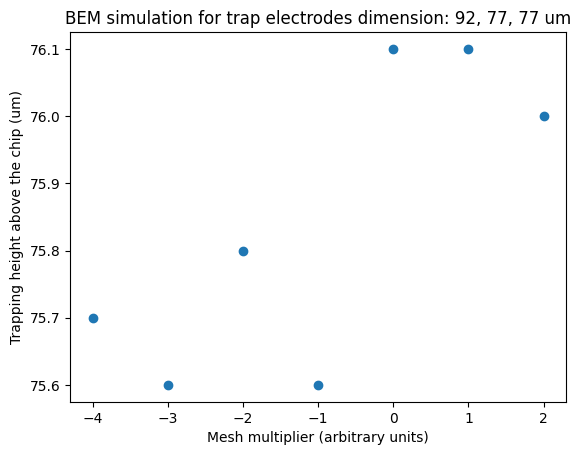

In [30]:
%matplotlib inline
plt.scatter(np.log2(mesh_factor), z0_arr);
plt.ylabel('Trapping height above the chip (um)');
plt.xlabel('Mesh multiplier (arbitrary units)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');

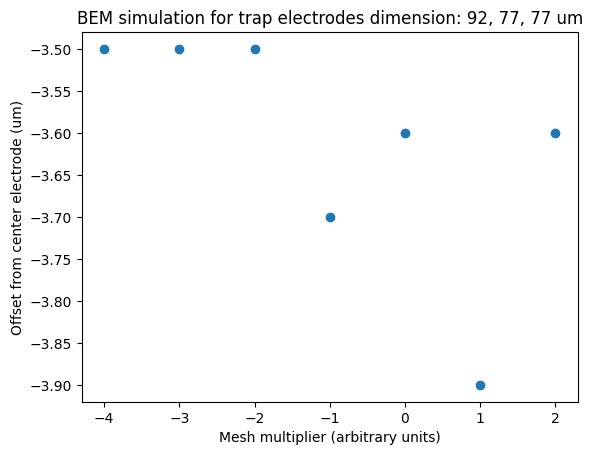

In [31]:
%matplotlib inline
plt.scatter(np.log2(mesh_factor), y0_arr);
plt.ylabel('Offset from center electrode (um)');
plt.xlabel('Mesh multiplier (arbitrary units)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');

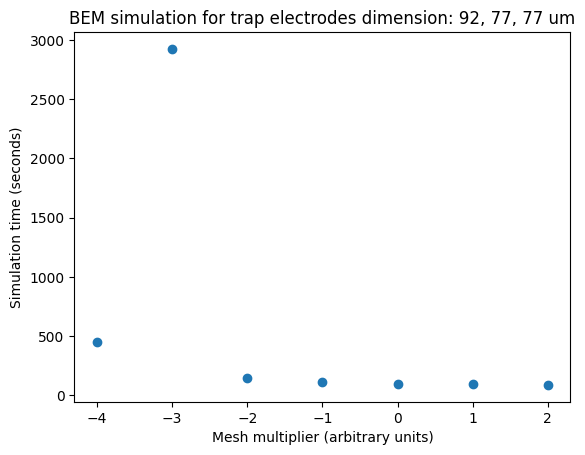

In [32]:
%matplotlib inline
plt.scatter(np.log2(mesh_factor), time_arr);
plt.ylabel('Simulation time (seconds)');
plt.xlabel('Mesh multiplier (arbitrary units)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');

In [33]:
# save the data

import scipy.io

path = '/Users/yiyangzhi/Library/CloudStorage/GoogleDrive-yiyang_zhi3@berkeley.edu/My Drive/Ming Wu Integrated Photonics Group/Simulations/MATLAB/BEM_results/'
scipy.io.savemat(path + 'Ba_with_cutout_conv_center.mat', {'Mesh': mesh_factor , 'Height': z0_arr, 'Offset': y0_arr, 'time': time_arr});

stable height is 76.8999931 um
stable displacement is 2.9 um towards the shorter RF electrode


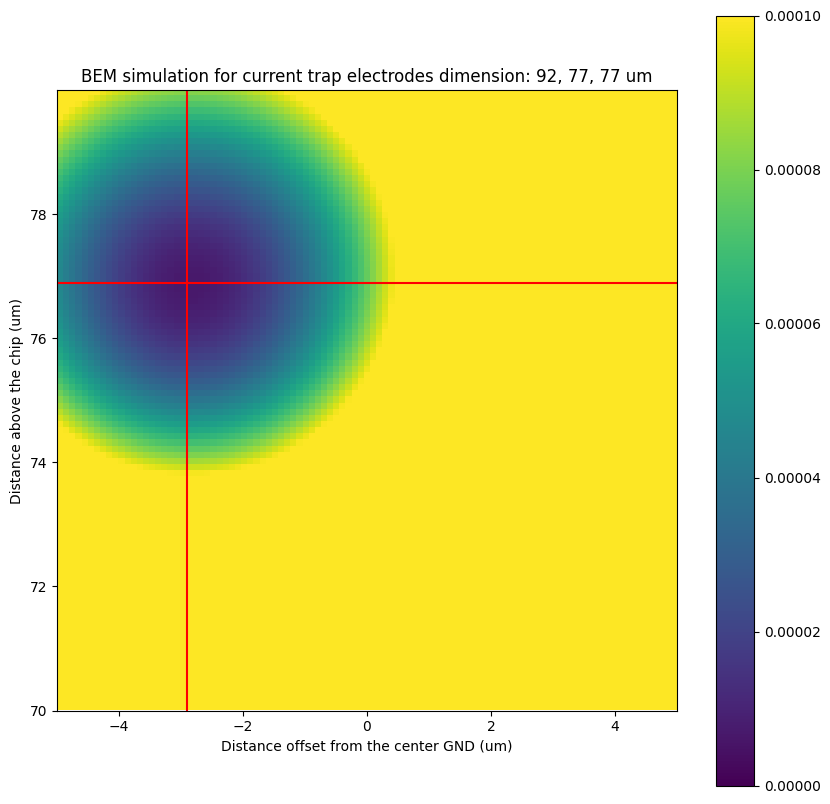

In [19]:
choose_ind = 0;
plt.figure(figsize=(10, 10))  # width, height in inches
plt.imshow(field_square_arr[choose_ind][0,:,:].transpose() ,extent=[grid[1][0]*a0*1e6 + (((0+7.929) + 77/2)), grid[1][-1]*a0*1e6 + (((0+7.929) + 77/2)), grid[2][0]*a0*1e6, grid[2][-1]*a0*1e6], origin='lower', cmap='viridis', interpolation = 'nearest', vmin=0, vmax=0.00010)
plt.colorbar()
plt.ylabel('Distance above the chip (um)');
plt.xlabel('Distance offset from the center GND (um)');
plt.title('BEM simulation for current trap electrodes dimension: 92, 77, 77 um');


out = np.where(field_square_arr[choose_ind] == field_square_arr[choose_ind][:-2, 2:-2].min());
select = 2;
z0 = grid[select][out[select][0]]*a0*1e6;
plt.axhline(z0, c='red');
select = 1;
y0= grid[select][out[select][0]]*a0*1e6 + 77/2 + 7.929
plt.axvline(y0, c='red');

print(f'stable height is {z0} um');
print(f'stable displacement is {np.round(-y0,3)} um towards the shorter RF electrode');


In [62]:
# sweep along the long dimension of the electrode

center_begin = 0;
center_end = 128;
center_step = 1;
center_arr = np.arange(center_begin, center_end+center_step, center_step);

field_square_arr = [];
time_arr = [];

for i in range(len(center_arr)):


    del mesh;

    #just create a new mesh every time
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=a0/unit, rename=ele_col.electrode_colors, quiet=True))

    #here is the location that will be the reference point for further meshing
    #usually, this is the ion's location, specified in a0 unit
    zl = 1;
    yl = (-7.929 - 77/2)/(a0*1e6);
    xl = center_arr[i];
    rad = 5;
    
    # 1. Global triangulation
    mesh.triangulate(opts="q20Q",new = False);
    
    # 2. Local triangulation
    # areas_from_constraints specifies sphere/cylinder with finer mesh inside it.
    # "inside", "outside" set different mesh densities.
    
    # first refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=1.*0.25, outside=2)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas

    # second refine
    mesh.areas_from_constraints(Sphere(center=np.array([xl, yl, zl]), radius=rad, inside=0.1*0.25, outside=20)); # Sphere constraint
    mesh.triangulate(opts="q20Q", new=False); # retriangulate quality and quiet with areas
    
    # 3. save base mesh to vtk
    mesh.to_vtk(prefix)
    print("Output vtk:",os.path.abspath("./"+prefix+".vtk"))    # output path

    # in um
    gap_top = -7.929;
    middle_electrode = -77;
    distance_ref1 = 3816;
    distance_ref2 = 4496;
    
    #define the physical distance I want to simulate, in um
    Lx_phy = 1;
    Ly_phy = 10;
    Lz_phy = 10;
    
    #define the physical step size I want, in um
    sx_phy = 1;
    sy_phy = 0.1;
    sz_phy = 0.1;
    
    #center
    center_x = distance_ref1/(a0*1e6);
    center_y = (gap_top+middle_electrode/2)/(a0*1e6);
    
    # grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
    Lx, Ly, Lz = Lx_phy / (a0*1e6), Ly_phy / (a0*1e6), Lz_phy / (a0*1e6)    # in the unit of scaled length l
    sx, sy, sz = sx_phy / (a0*1e6), sy_phy / (a0*1e6), sz_phy / (a0*1e6)
    # ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
    nx, ny, nz = [2*np.ceil(L/2.0/ss).astype('int')+1 for ss, L in zip((sx, sy, sz), (Lx, Ly, Lz))]
    print("Size/l:", Lx, Ly, Lz)
    print("Step/l:", sx, sy, sz)
    print("Shape (grid point numbers):", nx, ny, nz)
    grid = Grid(center=(center_arr[i], center_y, 75/(a0*1e6)), step=(sx, sy, sz), shape=(nx, ny, nz))
    # Grid center (nx, ny ,nz)/2 is shifted to origin
    print("Grid origin/l:", grid.get_origin()[0])

    # create job list
    jobs = list(Configuration.select(mesh,"RF"))
    # evaluate electric potential for each configurations: one electrode at 1V, the rest 0V.
    
    # parallel computation
    mycluster = ipp.Cluster()
    mycluster.start_cluster_sync()
    c = mycluster.connect_client_sync()
    c.wait_for_engines()
    
    t0 = time()
    # Run a parallel map, executing the wrapper function on indices 0,...,n-1
    lview = c.load_balanced_view()
    # Cause execution on main process to wait while tasks sent to workers finish
    lview.block = True 
    asyncresult = lview.map_async(run_job, ((job, grid, prefix) for job in jobs))   # Run calculation in parallel
    asyncresult.wait_interactive()
    print("Computing time: %f s"%(time()-t0))

    c.shutdown(hub=True);

    #save the result
    rf_result = Result.from_vtk(prefix, 'RF')
    grid = rf_result.grid.to_xyz() # access the (x, y, z) coordinates
    
    field_square_arr.append(rf_result.field_square); # access the simulated field_square data
    time_arr.append((time()-t0));    


dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12
final opts q20Qzr
finish triangulate DC12
start triangulate DC9
final opts q20Qzr
finish triangulate DC9
start triangulate DC5
final opts q20Qzr
finish triangulate DC5
start triangulate DC1
final opts q20Qzr
finish triangulate DC1
start triangulate DC2
final opts q20Qzr
finish triangulate DC2
start triangulate DC6
final opts q20Qzr
finish triangulate DC6
start triangulate DC10
final opts q20Qzr
finish triangulate DC10
start triangulate DC13
final opts q20Qzr
finish triangulate DC13
start triangulate DC17
final opts q20Qzr
finish triangulate DC17
start triangulate DC15
final opts q20Qzr
finish triangulate DC15
start triangulate DC19
final opts q20Qzr
finish triangulate DC19
start triangulate DC11
final opts q20Qzr
finish triangulate DC11
star

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 111.933092 s
engine set stopped 1718333312: {'engines': {'0': {'exit_code': 0, 'pid': 81076, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 81083, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 81091, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 81078, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 81095, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 81077, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 81106, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 81100, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 81087, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 81079, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81064, 'identifier': 'ipcontroller-1718333311-g4ad-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 114.053837 s
engine set stopped 1718333444: {'engines': {'5': {'exit_code': 0, 'pid': 81161, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 81153, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 81169, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 81156, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 81150, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 81174, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 81165, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 81152, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 81180, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 81151, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81138, 'identifier': 'ipcontroller-1718333443-4n6t-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 119.194626 s
engine set stopped 1718333578: {'engines': {'8': {'exit_code': 0, 'pid': 81248, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 81227, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 81244, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 81255, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 81226, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 81240, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 81229, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 81228, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 81230, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 81234, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81214, 'identifier': 'ipcontroller-1718333577-oknn-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 121.449437 s
engine set stopped 1718333718: {'engines': {'4': {'exit_code': 0, 'pid': 81335, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 81359, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 81330, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 81352, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 81350, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 81331, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 81345, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 81341, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 81332, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 81333, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81318, 'identifier': 'ipcontroller-1718333717-xh4t-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 122.960742 s
engine set stopped 1718333860: {'engines': {'0': {'exit_code': 0, 'pid': 81417, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 81444, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 81448, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 81424, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 81418, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 81438, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 81428, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 81432, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 81419, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 81420, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81405, 'identifier': 'ipcontroller-1718333859-bf4a-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 122.455647 s
engine set stopped 1718334003: {'engines': {'2': {'exit_code': 0, 'pid': 81506, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 81519, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 81504, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 81533, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 81522, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 81508, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 81505, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 81526, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 81515, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 81507, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81492, 'identifier': 'ipcontroller-1718334002-gi5g-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 123.008932 s
engine set stopped 1718334145: {'engines': {'1': {'exit_code': 0, 'pid': 81585, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 81587, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 81603, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 81609, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 81614, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 81584, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 81595, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 81586, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 81599, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 81590, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81572, 'identifier': 'ipcontroller-1718334144-i2cf-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 266.487529 s
engine set stopped 1718334288: {'engines': {'4': {'exit_code': 0, 'pid': 81665, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 81658, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 81660, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 81683, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 81661, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 81669, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 81659, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 81689, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 81677, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 81673, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81646, 'identifier': 'ipcontroller-1718334287-z4tj-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 820.081385 s
engine set stopped 1718334575: {'engines': {'0': {'exit_code': 0, 'pid': 81745, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 81775, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 81760, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 81764, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 81746, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 81756, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 81748, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 81772, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 81752, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 81747, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81733, 'identifier': 'ipcontroller-1718334574-gnca-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 121.817734 s
engine set stopped 1718335415: {'engines': {'2': {'exit_code': 0, 'pid': 81828, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 81837, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 81847, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 81827, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 81841, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 81856, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 81833, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 81829, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 81853, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 81826, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81814, 'identifier': 'ipcontroller-1718335414-s6ts-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 122.546623 s
engine set stopped 1718335557: {'engines': {'4': {'exit_code': 0, 'pid': 81915, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 81908, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 81909, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 81939, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 81923, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 81910, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 81935, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 81919, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 81927, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 81911, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81896, 'identifier': 'ipcontroller-1718335556-5jag-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 128.376355 s
engine set stopped 1718335700: {'engines': {'8': {'exit_code': 0, 'pid': 82021, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 82016, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 81995, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 82002, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 82010, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 81998, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 82006, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 82027, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 81997, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 81996, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 81983, 'identifier': 'ipcontroller-1718335699-epgk-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 127.852047 s
engine set stopped 1718335848: {'engines': {'2': {'exit_code': 0, 'pid': 82094, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 82095, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 82113, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 82099, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 82119, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 82092, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 82093, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 82103, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 82107, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 82124, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82080, 'identifier': 'ipcontroller-1718335847-nnfo-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 128.705856 s
engine set stopped 1718335996: {'engines': {'9': {'exit_code': 0, 'pid': 82204, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 82194, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 82174, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 82175, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 82173, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 82188, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 82200, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 82184, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 82180, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 82176, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82161, 'identifier': 'ipcontroller-1718335995-uyo5-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.104033 s
engine set stopped 1718336145: {'engines': {'8': {'exit_code': 0, 'pid': 82277, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 82252, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 82266, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 82262, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 82258, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 82282, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 82272, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 82254, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 82251, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 82253, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82239, 'identifier': 'ipcontroller-1718336144-u0m9-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 131.403386 s
engine set stopped 1718336295: {'engines': {'9': {'exit_code': 0, 'pid': 82357, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 82327, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 82324, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 82339, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 82351, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 82331, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 82345, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 82325, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 82326, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 82335, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82312, 'identifier': 'ipcontroller-1718336294-r9rp-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.002184 s
engine set stopped 1718336446: {'engines': {'5': {'exit_code': 0, 'pid': 82462, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 82451, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 82484, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 82458, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 82453, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 82472, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 82454, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 82452, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 82478, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 82466, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82439, 'identifier': 'ipcontroller-1718336445-1sl2-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 134.857084 s
engine set stopped 1718336596: {'engines': {'3': {'exit_code': 0, 'pid': 82530, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 82548, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 82528, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 82538, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 82554, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 82529, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 82527, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 82542, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 82534, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 82558, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82515, 'identifier': 'ipcontroller-1718336595-yl65-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 136.050573 s
engine set stopped 1718336751: {'engines': {'7': {'exit_code': 0, 'pid': 82638, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 82652, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 82621, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 82622, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 82634, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 82646, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 82626, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 82630, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 82619, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 82620, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82607, 'identifier': 'ipcontroller-1718336750-c5c7-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 136.700774 s
engine set stopped 1718336907: {'engines': {'9': {'exit_code': 0, 'pid': 82726, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 82704, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 82700, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 82694, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 82714, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 82708, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 82696, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 82695, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 82720, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 82693, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82681, 'identifier': 'ipcontroller-1718336906-hjnl-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 129.624574 s
engine set stopped 1718337064: {'engines': {'0': {'exit_code': 0, 'pid': 82795, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 82796, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 82806, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 82798, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 82816, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 82802, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 82810, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 82797, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 82827, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 82822, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82783, 'identifier': 'ipcontroller-1718337063-u06l-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 141.962295 s
engine set stopped 1718337213: {'engines': {'3': {'exit_code': 0, 'pid': 82889, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 82907, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 82888, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 82886, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 82887, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 82919, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 82897, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 82901, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 82913, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 82893, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82874, 'identifier': 'ipcontroller-1718337212-ofn4-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 135.787576 s
engine set stopped 1718337375: {'engines': {'0': {'exit_code': 0, 'pid': 82971, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 82972, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 82977, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 82990, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 82973, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 82996, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 82981, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 82974, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 82985, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 83002, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 82959, 'identifier': 'ipcontroller-1718337374-ifh4-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 132.881742 s
engine set stopped 1718337531: {'engines': {'9': {'exit_code': 0, 'pid': 83080, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 83050, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 83054, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 83058, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 83047, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 83062, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 83049, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 83074, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 83068, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 83048, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83035, 'identifier': 'ipcontroller-1718337530-3oub-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 131.239800 s
engine set stopped 1718337684: {'engines': {'0': {'exit_code': 0, 'pid': 83127, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 83129, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 83128, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 83130, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 83159, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 83134, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 83148, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 83138, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 83154, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 83142, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83115, 'identifier': 'ipcontroller-1718337683-rzuf-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 133.810244 s
engine set stopped 1718337835: {'engines': {'0': {'exit_code': 0, 'pid': 83221, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 83224, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 83222, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 83232, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 83236, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 83242, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 83254, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 83228, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 83223, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 83248, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83209, 'identifier': 'ipcontroller-1718337834-y2uq-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.289421 s
engine set stopped 1718337989: {'engines': {'2': {'exit_code': 0, 'pid': 83299, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 83298, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 83312, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 83300, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 83297, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 83324, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 83304, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 83318, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 83330, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 83308, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83285, 'identifier': 'ipcontroller-1718337988-fj08-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 144.905986 s
engine set stopped 1718338155: {'engines': {'7': {'exit_code': 0, 'pid': 83408, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 83392, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 83390, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 83416, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 83400, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 83422, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 83404, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 83391, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 83389, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 83396, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83377, 'identifier': 'ipcontroller-1718338154-l5wg-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 140.090692 s
engine set stopped 1718338320: {'engines': {'0': {'exit_code': 0, 'pid': 83473, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 83476, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 83505, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 83494, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 83488, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 83484, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 83500, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 83474, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 83475, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 83480, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83461, 'identifier': 'ipcontroller-1718338319-k8he-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 154.477610 s
engine set stopped 1718338480: {'engines': {'7': {'exit_code': 0, 'pid': 83567, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 83549, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 83553, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 83546, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 83547, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 83561, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 83574, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 83548, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 83557, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 83580, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83534, 'identifier': 'ipcontroller-1718338479-kgjt-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 159.510854 s
engine set stopped 1718338655: {'engines': {'1': {'exit_code': 0, 'pid': 83625, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 83635, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 83651, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 83639, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 83626, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 83631, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 83645, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 83627, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 83656, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 83624, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83612, 'identifier': 'ipcontroller-1718338654-lwew-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 159.334505 s
engine set stopped 1718338835: {'engines': {'4': {'exit_code': 0, 'pid': 83709, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 83703, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 83721, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 83728, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 83702, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 83713, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 83704, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 83735, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 83705, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 83717, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83690, 'identifier': 'ipcontroller-1718338833-76f5-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 160.262638 s
engine set stopped 1718339014: {'engines': {'9': {'exit_code': 0, 'pid': 83813, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 83804, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 83784, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 83785, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 83786, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 83810, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 83783, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 83794, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 83798, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 83790, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83771, 'identifier': 'ipcontroller-1718339013-olke-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 161.785986 s
engine set stopped 1718339194: {'engines': {'0': {'exit_code': 0, 'pid': 83871, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 83878, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 83898, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 83882, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 83886, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 83874, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 83872, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 83873, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 83890, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 83904, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83859, 'identifier': 'ipcontroller-1718339193-ah65-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 159.199109 s
engine set stopped 1718339376: {'engines': {'0': {'exit_code': 0, 'pid': 83984, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 83986, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 83999, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 84011, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 84019, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 84003, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 83987, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 83991, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 83985, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 83995, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 83972, 'identifier': 'ipcontroller-1718339375-qx0j-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.536213 s
engine set stopped 1718339556: {'engines': {'0': {'exit_code': 0, 'pid': 84090, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 84122, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 84091, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 84092, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 84101, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 84117, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 84105, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 84093, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 84111, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 84097, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84078, 'identifier': 'ipcontroller-1718339555-8tkd-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 154.129713 s
engine set stopped 1718339722: {'engines': {'3': {'exit_code': 0, 'pid': 84186, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 84185, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 84190, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 84198, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 84216, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 84204, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 84210, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 84194, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 84184, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 84183, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84170, 'identifier': 'ipcontroller-1718339721-893k-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 149.300910 s
engine set stopped 1718339896: {'engines': {'6': {'exit_code': 0, 'pid': 84273, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 84285, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 84265, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 84259, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 84279, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 84291, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 84261, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 84260, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 84258, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 84269, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84246, 'identifier': 'ipcontroller-1718339895-70el-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.481923 s
engine set stopped 1718340066: {'engines': {'1': {'exit_code': 0, 'pid': 84396, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 84406, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 84416, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 84402, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 84395, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 84428, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 84422, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 84397, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 84410, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 84398, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84383, 'identifier': 'ipcontroller-1718340064-9z1j-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 145.775394 s
engine set stopped 1718340234: {'engines': {'6': {'exit_code': 0, 'pid': 84486, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 84471, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 84472, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 84474, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 84473, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 84498, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 84492, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 84504, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 84478, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 84482, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84459, 'identifier': 'ipcontroller-1718340233-7r8t-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 150.919834 s
engine set stopped 1718340400: {'engines': {'0': {'exit_code': 0, 'pid': 84550, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 84553, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 84580, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 84557, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 84565, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 84568, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 84552, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 84574, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 84551, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 84561, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84538, 'identifier': 'ipcontroller-1718340399-0id2-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 147.548019 s
engine set stopped 1718340571: {'engines': {'8': {'exit_code': 0, 'pid': 84663, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 84636, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 84639, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 84647, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 84638, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 84643, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 84637, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 84651, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 84669, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 84657, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84624, 'identifier': 'ipcontroller-1718340570-sgxv-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 143.809804 s
engine set stopped 1718340738: {'engines': {'0': {'exit_code': 0, 'pid': 84732, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 84735, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 84743, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 84747, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 84739, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 84775, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 84733, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 84734, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 84761, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 84769, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84720, 'identifier': 'ipcontroller-1718340737-03x1-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.025267 s
engine set stopped 1718340902: {'engines': {'6': {'exit_code': 0, 'pid': 84832, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 84838, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 84824, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 84818, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 84850, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 84820, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 84844, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 84819, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 84817, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 84828, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84805, 'identifier': 'ipcontroller-1718340901-qeeg-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.654953 s
engine set stopped 1718341070: {'engines': {'3': {'exit_code': 0, 'pid': 84899, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 84907, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 84923, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 84903, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 84897, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 84911, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 84896, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 84928, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 84917, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 84898, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84884, 'identifier': 'ipcontroller-1718341069-d6ez-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.308029 s
engine set stopped 1718341238: {'engines': {'0': {'exit_code': 0, 'pid': 84981, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 84983, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 85002, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 84988, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 85014, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 84992, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 84984, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 85008, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 84982, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 84996, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 84969, 'identifier': 'ipcontroller-1718341237-po5r-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.178977 s
engine set stopped 1718341404: {'engines': {'0': {'exit_code': 0, 'pid': 85072, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 85105, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 85075, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 85099, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 85083, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 85074, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 85087, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 85073, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 85079, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 85093, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85060, 'identifier': 'ipcontroller-1718341403-3p6q-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 147.187895 s
engine set stopped 1718341571: {'engines': {'8': {'exit_code': 0, 'pid': 85176, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 85149, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 85150, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 85152, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 85182, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 85151, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 85164, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 85160, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 85170, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 85156, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85137, 'identifier': 'ipcontroller-1718341570-6g54-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 145.036171 s
engine set stopped 1718341738: {'engines': {'0': {'exit_code': 0, 'pid': 85225, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 85232, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 85227, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 85258, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 85236, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 85228, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 85226, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 85252, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 85240, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 85246, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85212, 'identifier': 'ipcontroller-1718341737-5mh3-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.401309 s
engine set stopped 1718341903: {'engines': {'7': {'exit_code': 0, 'pid': 85332, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 85344, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 85311, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 85314, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 85322, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 85313, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 85326, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 85338, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 85318, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 85312, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85299, 'identifier': 'ipcontroller-1718341902-rlus-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 144.357715 s
engine set stopped 1718342069: {'engines': {'9': {'exit_code': 0, 'pid': 85418, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 85388, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 85412, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 85386, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 85392, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 85385, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 85387, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 85400, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 85396, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 85406, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85373, 'identifier': 'ipcontroller-1718342068-8n8s-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 139.733477 s
engine set stopped 1718342233: {'engines': {'2': {'exit_code': 0, 'pid': 85464, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 85462, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 85465, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 85463, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 85477, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 85483, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 85495, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 85469, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 85473, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 85489, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85450, 'identifier': 'ipcontroller-1718342232-csx4-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 139.564991 s
engine set stopped 1718342393: {'engines': {'4': {'exit_code': 0, 'pid': 85544, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 85564, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 85538, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 85570, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 85540, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 85537, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 85552, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 85558, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 85539, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 85548, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85525, 'identifier': 'ipcontroller-1718342392-mgm2-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 136.384746 s
engine set stopped 1718342552: {'engines': {'5': {'exit_code': 0, 'pid': 85625, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 85617, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 85621, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 85629, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 85647, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 85614, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 85641, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 85616, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 85635, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 85615, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85602, 'identifier': 'ipcontroller-1718342551-mwgr-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 137.085913 s
engine set stopped 1718342708: {'engines': {'9': {'exit_code': 0, 'pid': 85723, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 85693, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 85712, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 85698, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 85718, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 85692, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 85706, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 85694, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 85702, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 85691, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85679, 'identifier': 'ipcontroller-1718342707-o368-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 136.486704 s
engine set stopped 1718342865: {'engines': {'6': {'exit_code': 0, 'pid': 85784, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 85769, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 85770, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 85796, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 85771, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 85772, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 85802, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 85780, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 85776, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 85790, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85757, 'identifier': 'ipcontroller-1718342864-l0vr-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 136.413025 s
engine set stopped 1718343022: {'engines': {'8': {'exit_code': 0, 'pid': 85884, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 85860, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 85890, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 85868, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 85857, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 85859, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 85878, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 85858, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 85872, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 85864, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85844, 'identifier': 'ipcontroller-1718343021-r6nw-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 138.823891 s
engine set stopped 1718343178: {'engines': {'9': {'exit_code': 0, 'pid': 85983, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 85950, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 85971, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 85952, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 85953, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 85977, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 85957, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 85961, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 85951, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 85965, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 85938, 'identifier': 'ipcontroller-1718343177-g5u8-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 138.529466 s
engine set stopped 1718343337: {'engines': {'2': {'exit_code': 0, 'pid': 86029, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 86060, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 86028, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 86034, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 86038, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 86054, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 86030, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 86042, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 86027, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 86048, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86015, 'identifier': 'ipcontroller-1718343336-l5k2-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 141.224905 s
engine set stopped 1718343495: {'engines': {'1': {'exit_code': 0, 'pid': 86106, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 86105, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 86126, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 86108, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 86112, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 86132, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 86120, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 86138, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 86116, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 86107, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86093, 'identifier': 'ipcontroller-1718343494-cxuf-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 138.701346 s
engine set stopped 1718343656: {'engines': {'2': {'exit_code': 0, 'pid': 86233, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 86238, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 86231, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 86258, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 86232, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 86234, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 86242, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 86264, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 86246, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 86252, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86219, 'identifier': 'ipcontroller-1718343655-sd8a-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 139.339491 s
engine set stopped 1718343815: {'engines': {'6': {'exit_code': 0, 'pid': 86327, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 86345, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 86315, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 86319, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 86333, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 86323, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 86312, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 86314, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 86313, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 86339, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86298, 'identifier': 'ipcontroller-1718343814-717t-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 142.085286 s
engine set stopped 1718343974: {'engines': {'9': {'exit_code': 0, 'pid': 86423, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 86393, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 86401, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 86397, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 86411, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 86391, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 86417, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 86390, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 86392, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 86405, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86378, 'identifier': 'ipcontroller-1718343973-c4au-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 141.578965 s
engine set stopped 1718344136: {'engines': {'2': {'exit_code': 0, 'pid': 86466, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 86491, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 86475, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 86485, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 86464, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 86479, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 86467, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 86465, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 86471, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 86497, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86452, 'identifier': 'ipcontroller-1718344135-jwkb-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 142.204760 s
engine set stopped 1718344297: {'engines': {'0': {'exit_code': 0, 'pid': 86562, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 86565, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 86595, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 86574, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 86584, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 86590, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 86563, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 86578, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 86570, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 86564, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86550, 'identifier': 'ipcontroller-1718344296-0qf6-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 140.394151 s
engine set stopped 1718344459: {'engines': {'0': {'exit_code': 0, 'pid': 86639, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 86642, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 86654, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 86640, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 86666, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 86650, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 86660, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 86641, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 86646, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 86672, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86627, 'identifier': 'ipcontroller-1718344458-fu2b-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 137.335616 s
engine set stopped 1718344619: {'engines': {'1': {'exit_code': 0, 'pid': 86717, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 86727, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 86719, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 86716, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 86737, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 86723, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 86731, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 86743, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 86718, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 86749, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86704, 'identifier': 'ipcontroller-1718344618-h2p8-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 141.119608 s
engine set stopped 1718344776: {'engines': {'2': {'exit_code': 0, 'pid': 86793, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 86812, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 86792, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 86802, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 86794, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 86798, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 86818, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 86806, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 86824, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 86791, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86779, 'identifier': 'ipcontroller-1718344775-gvdu-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 140.080941 s
engine set stopped 1718344937: {'engines': {'4': {'exit_code': 0, 'pid': 86890, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 86883, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 86916, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 86910, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 86884, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 86898, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 86894, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 86885, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 86886, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 86904, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86871, 'identifier': 'ipcontroller-1718344936-m0lz-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 139.351664 s
engine set stopped 1718345097: {'engines': {'7': {'exit_code': 0, 'pid': 86983, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 86969, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 86962, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 86973, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 86977, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 86964, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 86995, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 86965, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 86963, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 86989, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 86950, 'identifier': 'ipcontroller-1718345096-1rso-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 142.002701 s
engine set stopped 1718345256: {'engines': {'2': {'exit_code': 0, 'pid': 87041, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 87040, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 87042, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 87066, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 87054, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 87039, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 87050, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 87072, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 87046, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 87060, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87027, 'identifier': 'ipcontroller-1718345255-k1rn-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 143.943509 s
engine set stopped 1718345418: {'engines': {'5': {'exit_code': 0, 'pid': 87136, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 87126, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 87140, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 87127, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 87152, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 87158, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 87132, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 87146, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 87128, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 87125, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87113, 'identifier': 'ipcontroller-1718345417-o6as-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.763849 s
engine set stopped 1718345582: {'engines': {'9': {'exit_code': 0, 'pid': 87238, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 87216, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 87208, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 87207, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 87205, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 87232, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 87220, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 87226, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 87212, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 87206, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87193, 'identifier': 'ipcontroller-1718345581-zma4-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 147.932782 s
engine set stopped 1718345751: {'engines': {'0': {'exit_code': 0, 'pid': 87282, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 87293, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 87283, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 87284, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 87289, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 87297, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 87285, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 87309, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 87315, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 87303, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87270, 'identifier': 'ipcontroller-1718345750-7v7x-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.661371 s
engine set stopped 1718345919: {'engines': {'2': {'exit_code': 0, 'pid': 87359, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 87368, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 87378, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 87360, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 87384, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 87357, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 87364, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 87390, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 87358, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 87372, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87345, 'identifier': 'ipcontroller-1718345918-kksj-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 150.041695 s
engine set stopped 1718346087: {'engines': {'6': {'exit_code': 0, 'pid': 87451, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 87443, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 87457, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 87447, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 87469, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 87437, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 87439, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 87436, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 87463, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 87438, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87424, 'identifier': 'ipcontroller-1718346086-8p8w-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 140.762120 s
engine set stopped 1718346257: {'engines': {'8': {'exit_code': 0, 'pid': 87570, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 87543, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 87544, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 87550, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 87545, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 87546, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 87554, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 87558, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 87564, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 87576, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87531, 'identifier': 'ipcontroller-1718346256-wu97-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 142.593236 s
engine set stopped 1718346418: {'engines': {'4': {'exit_code': 0, 'pid': 87634, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 87648, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 87660, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 87642, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 87628, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 87638, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 87627, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 87630, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 87654, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 87629, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87615, 'identifier': 'ipcontroller-1718346417-lof6-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 145.731024 s
engine set stopped 1718346580: {'engines': {'9': {'exit_code': 0, 'pid': 87760, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 87727, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 87729, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 87730, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 87738, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 87734, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 87748, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 87742, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 87754, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 87728, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87715, 'identifier': 'ipcontroller-1718346579-65o9-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 150.283736 s
engine set stopped 1718346746: {'engines': {'2': {'exit_code': 0, 'pid': 87825, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 87844, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 87856, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 87830, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 87824, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 87850, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 87826, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 87838, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 87823, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 87834, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87811, 'identifier': 'ipcontroller-1718346745-bowu-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.977696 s
engine set stopped 1718346916: {'engines': {'3': {'exit_code': 0, 'pid': 87903, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 87907, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 87902, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 87933, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 87915, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 87911, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 87900, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 87920, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 87927, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 87901, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87888, 'identifier': 'ipcontroller-1718346915-y4ef-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 149.174353 s
engine set stopped 1718347083: {'engines': {'4': {'exit_code': 0, 'pid': 87987, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 88007, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 87995, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 88013, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 88001, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 87983, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 87982, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 87991, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 87980, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 87981, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 87968, 'identifier': 'ipcontroller-1718347082-grum-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.089121 s
engine set stopped 1718347252: {'engines': {'2': {'exit_code': 0, 'pid': 88117, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 88126, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 88136, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 88116, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 88130, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 88142, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 88118, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 88148, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 88115, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 88122, 'identifier': '4'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88103, 'identifier': 'ipcontroller-1718347251-4ig7-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 144.597136 s
engine set stopped 1718347418: {'engines': {'9': {'exit_code': 0, 'pid': 88225, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 88219, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 88207, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 88199, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 88203, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 88192, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 88194, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 88195, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 88193, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 88213, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88180, 'identifier': 'ipcontroller-1718347417-3t8k-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 142.588403 s
engine set stopped 1718347583: {'engines': {'3': {'exit_code': 0, 'pid': 88282, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 88300, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 88312, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 88294, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 88280, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 88279, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 88286, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 88306, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 88281, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 88290, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88267, 'identifier': 'ipcontroller-1718347582-dswo-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 147.826221 s
engine set stopped 1718347745: {'engines': {'5': {'exit_code': 0, 'pid': 88364, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 88353, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 88380, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 88360, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 88354, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 88355, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 88386, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 88368, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 88356, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 88374, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88341, 'identifier': 'ipcontroller-1718347744-kw7l-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.919201 s
engine set stopped 1718347913: {'engines': {'0': {'exit_code': 0, 'pid': 88448, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 88449, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 88469, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 88475, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 88451, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 88455, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 88450, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 88459, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 88481, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 88463, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88436, 'identifier': 'ipcontroller-1718347912-xkyp-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 145.565063 s
engine set stopped 1718348082: {'engines': {'1': {'exit_code': 0, 'pid': 88525, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 88531, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 88545, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 88551, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 88526, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 88524, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 88539, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 88535, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 88527, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 88557, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88512, 'identifier': 'ipcontroller-1718348081-cjh7-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 148.888706 s
engine set stopped 1718348248: {'engines': {'3': {'exit_code': 0, 'pid': 88606, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 88636, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 88603, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 88614, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 88630, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 88605, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 88618, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 88624, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 88610, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 88604, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88591, 'identifier': 'ipcontroller-1718348247-sssx-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 147.670006 s
engine set stopped 1718348417: {'engines': {'1': {'exit_code': 0, 'pid': 88687, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 88719, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 88693, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 88697, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 88686, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 88688, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 88707, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 88701, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 88689, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 88713, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88674, 'identifier': 'ipcontroller-1718348415-ybnj-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 146.779776 s
engine set stopped 1718348584: {'engines': {'1': {'exit_code': 0, 'pid': 88777, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 88791, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 88803, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 88783, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 88779, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 88778, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 88787, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 88797, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 88776, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 88809, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88764, 'identifier': 'ipcontroller-1718348583-vyh2-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 145.731004 s
engine set stopped 1718348751: {'engines': {'8': {'exit_code': 0, 'pid': 88891, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 88885, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 88871, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 88875, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 88866, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 88897, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 88865, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 88879, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 88867, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 88864, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88852, 'identifier': 'ipcontroller-1718348750-iply-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 140.377980 s
engine set stopped 1718348917: {'engines': {'3': {'exit_code': 0, 'pid': 88953, 'identifier': '3'}, '1': {'exit_code': 0, 'pid': 88951, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 88971, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 88977, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 88983, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 88950, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 88957, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 88961, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 88952, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 88965, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 88938, 'identifier': 'ipcontroller-1718348916-r9st-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.220887 s
engine set stopped 1718349077: {'engines': {'2': {'exit_code': 0, 'pid': 89039, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 89053, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 89037, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 89038, 'identifier': '1'}, '4': {'exit_code': 0, 'pid': 89044, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 89070, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 89048, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 89040, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 89057, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 89065, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89025, 'identifier': 'ipcontroller-1718349076-my2f-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 129.072131 s
engine set stopped 1718349227: {'engines': {'3': {'exit_code': 0, 'pid': 89115, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 89145, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 89119, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 89114, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 89133, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 89139, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 89127, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 89112, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 89123, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 89113, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89100, 'identifier': 'ipcontroller-1718349226-58ws-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 122.129874 s
engine set stopped 1718349376: {'engines': {'8': {'exit_code': 0, 'pid': 89217, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 89205, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 89197, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 89211, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 89192, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 89190, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 89193, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 89201, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 89223, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 89191, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89178, 'identifier': 'ipcontroller-1718349375-muku-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 119.273166 s
engine set stopped 1718349518: {'engines': {'2': {'exit_code': 0, 'pid': 89266, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 89264, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 89271, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89279, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 89267, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 89285, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 89291, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 89297, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 89265, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 89275, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89252, 'identifier': 'ipcontroller-1718349517-2v2k-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 121.049393 s
engine set stopped 1718349658: {'engines': {'0': {'exit_code': 0, 'pid': 89347, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 89355, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89364, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 89350, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 89376, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 89370, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 89348, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 89349, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 89382, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 89360, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89335, 'identifier': 'ipcontroller-1718349657-7zy6-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 119.076771 s
engine set stopped 1718349799: {'engines': {'3': {'exit_code': 0, 'pid': 89426, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 89457, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 89424, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 89425, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 89450, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 89430, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89438, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 89423, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 89444, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 89434, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89411, 'identifier': 'ipcontroller-1718349798-y9qc-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 123.089418 s
engine set stopped 1718349938: {'engines': {'1': {'exit_code': 0, 'pid': 89502, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 89522, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 89512, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 89508, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89516, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 89501, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 89504, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 89528, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 89503, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 89534, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89489, 'identifier': 'ipcontroller-1718349937-9sq5-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 119.484493 s
engine set stopped 1718350080: {'engines': {'2': {'exit_code': 0, 'pid': 89581, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 89606, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 89612, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 89590, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 89580, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 89582, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 89600, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 89586, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89594, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 89579, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89567, 'identifier': 'ipcontroller-1718350079-fhzw-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 124.432445 s
engine set stopped 1718350220: {'engines': {'4': {'exit_code': 0, 'pid': 89675, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 89689, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 89668, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 89683, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 89671, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 89670, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 89679, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 89695, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 89669, 'identifier': '1'}, '9': {'exit_code': 0, 'pid': 89701, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89656, 'identifier': 'ipcontroller-1718350219-oc2j-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.435836 s
engine set stopped 1718350364: {'engines': {'6': {'exit_code': 0, 'pid': 89777, 'identifier': '6'}, '4': {'exit_code': 0, 'pid': 89769, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 89765, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 89773, 'identifier': '5'}, '9': {'exit_code': 0, 'pid': 89795, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 89763, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 89764, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 89762, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 89783, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 89789, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89750, 'identifier': 'ipcontroller-1718350363-7aoz-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 126.108099 s
engine set stopped 1718350515: {'engines': {'9': {'exit_code': 0, 'pid': 89872, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 89839, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 89860, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 89846, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 89842, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 89841, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 89866, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 89854, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 89840, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 89850, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89827, 'identifier': 'ipcontroller-1718350514-vt52-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 129.886469 s
engine set stopped 1718350661: {'engines': {'3': {'exit_code': 0, 'pid': 89929, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 89959, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 89927, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 89953, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 89947, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 89926, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 89937, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 89928, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 89933, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 89941, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 89914, 'identifier': 'ipcontroller-1718350660-rv0b-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.894763 s
engine set stopped 1718350811: {'engines': {'8': {'exit_code': 0, 'pid': 90084, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 90072, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 90059, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 90058, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 90060, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 90068, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 90057, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 90090, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 90064, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 90078, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90045, 'identifier': 'ipcontroller-1718350810-vzb1-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 130.354727 s
engine set stopped 1718350962: {'engines': {'0': {'exit_code': 0, 'pid': 90133, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 90134, 'identifier': '1'}, '3': {'exit_code': 0, 'pid': 90136, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 90166, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 90144, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 90135, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 90154, 'identifier': '7'}, '4': {'exit_code': 0, 'pid': 90140, 'identifier': '4'}, '8': {'exit_code': 0, 'pid': 90160, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 90148, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90121, 'identifier': 'ipcontroller-1718350960-493l-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 128.046019 s
engine set stopped 1718351112: {'engines': {'9': {'exit_code': 0, 'pid': 90243, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 90237, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 90212, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 90221, 'identifier': '5'}, '2': {'exit_code': 0, 'pid': 90211, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 90216, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 90231, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 90209, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 90210, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 90225, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90197, 'identifier': 'ipcontroller-1718351111-yx0y-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 124.554056 s
engine set stopped 1718351260: {'engines': {'7': {'exit_code': 0, 'pid': 90308, 'identifier': '7'}, '5': {'exit_code': 0, 'pid': 90298, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 90294, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 90302, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 90290, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 90320, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 90287, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 90289, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 90314, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 90288, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90275, 'identifier': 'ipcontroller-1718351259-ffsw-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 121.323873 s
engine set stopped 1718351405: {'engines': {'9': {'exit_code': 0, 'pid': 90397, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 90366, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 90375, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 90364, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 90371, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 90385, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 90367, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 90391, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 90365, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 90379, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90350, 'identifier': 'ipcontroller-1718351404-5i8c-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 121.261573 s
engine set stopped 1718351546: {'engines': {'7': {'exit_code': 0, 'pid': 90485, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 90467, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 90491, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 90464, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 90475, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 90471, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 90497, 'identifier': '9'}, '6': {'exit_code': 0, 'pid': 90479, 'identifier': '6'}, '2': {'exit_code': 0, 'pid': 90466, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 90465, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90452, 'identifier': 'ipcontroller-1718351545-fe63-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 113.544432 s
engine set stopped 1718351687: {'engines': {'5': {'exit_code': 0, 'pid': 90548, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 90538, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 90564, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 90544, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 90570, 'identifier': '9'}, '7': {'exit_code': 0, 'pid': 90558, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 90539, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 90540, 'identifier': '3'}, '6': {'exit_code': 0, 'pid': 90552, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 90537, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90525, 'identifier': 'ipcontroller-1718351686-ufy4-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 116.324336 s
engine set stopped 1718351821: {'engines': {'1': {'exit_code': 0, 'pid': 90616, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 90630, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 90615, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 90622, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 90648, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 90617, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 90642, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 90636, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 90618, 'identifier': '3'}, '5': {'exit_code': 0, 'pid': 90626, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90603, 'identifier': 'ipcontroller-1718351820-ogw0-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 111.263480 s
engine set stopped 1718351957: {'engines': {'4': {'exit_code': 0, 'pid': 90697, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 90705, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 90691, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 90711, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 90723, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 90701, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 90690, 'identifier': '0'}, '2': {'exit_code': 0, 'pid': 90692, 'identifier': '2'}, '8': {'exit_code': 0, 'pid': 90717, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 90693, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90678, 'identifier': 'ipcontroller-1718351956-th1j-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 112.660816 s
engine set stopped 1718352088: {'engines': {'4': {'exit_code': 0, 'pid': 90775, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 90769, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 90795, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 90771, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 90770, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 90801, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 90779, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 90768, 'identifier': '0'}, '6': {'exit_code': 0, 'pid': 90783, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 90789, 'identifier': '7'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90756, 'identifier': 'ipcontroller-1718352087-t0qn-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 112.733556 s
engine set stopped 1718352221: {'engines': {'0': {'exit_code': 0, 'pid': 90859, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 90862, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 90866, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 90874, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 90860, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 90861, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 90892, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 90870, 'identifier': '5'}, '7': {'exit_code': 0, 'pid': 90880, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 90886, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90847, 'identifier': 'ipcontroller-1718352220-8qfu-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 116.021774 s
engine set stopped 1718352353: {'engines': {'7': {'exit_code': 0, 'pid': 90956, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 90968, 'identifier': '9'}, '5': {'exit_code': 0, 'pid': 90946, 'identifier': '5'}, '8': {'exit_code': 0, 'pid': 90962, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 90942, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 90938, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 90937, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 90936, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 90950, 'identifier': '6'}, '0': {'exit_code': 0, 'pid': 90935, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90923, 'identifier': 'ipcontroller-1718352352-s6b0-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 112.334727 s
engine set stopped 1718352489: {'engines': {'5': {'exit_code': 0, 'pid': 91019, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 91011, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 91029, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 91008, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 91035, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 91010, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 91015, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 91023, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 91041, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 91009, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 90996, 'identifier': 'ipcontroller-1718352488-giyz-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 117.673627 s
engine set stopped 1718352621: {'engines': {'8': {'exit_code': 0, 'pid': 91121, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 91095, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 91096, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 91101, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 91105, 'identifier': '5'}, '3': {'exit_code': 0, 'pid': 91097, 'identifier': '3'}, '9': {'exit_code': 0, 'pid': 91127, 'identifier': '9'}, '0': {'exit_code': 0, 'pid': 91094, 'identifier': '0'}, '7': {'exit_code': 0, 'pid': 91115, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 91109, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91082, 'identifier': 'ipcontroller-1718352620-titr-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 116.323065 s
engine set stopped 1718352759: {'engines': {'8': {'exit_code': 0, 'pid': 91197, 'identifier': '8'}, '1': {'exit_code': 0, 'pid': 91171, 'identifier': '1'}, '6': {'exit_code': 0, 'pid': 91185, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 91191, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 91173, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 91170, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 91181, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 91177, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 91203, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 91172, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91158, 'identifier': 'ipcontroller-1718352758-9tut-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 113.049770 s
engine set stopped 1718352896: {'engines': {'2': {'exit_code': 0, 'pid': 91326, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 91357, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 91331, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 91327, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 91351, 'identifier': '8'}, '7': {'exit_code': 0, 'pid': 91345, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 91339, 'identifier': '6'}, '1': {'exit_code': 0, 'pid': 91325, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 91335, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 91324, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91312, 'identifier': 'ipcontroller-1718352895-kfsz-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 107.320741 s
engine set stopped 1718353029: {'engines': {'9': {'exit_code': 0, 'pid': 91432, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 91401, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 91400, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 91399, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 91402, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 91406, 'identifier': '4'}, '7': {'exit_code': 0, 'pid': 91420, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 91426, 'identifier': '8'}, '5': {'exit_code': 0, 'pid': 91410, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 91414, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91387, 'identifier': 'ipcontroller-1718353028-wj1z-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 103.883911 s
engine set stopped 1718353156: {'engines': {'3': {'exit_code': 0, 'pid': 91476, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 91480, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 91484, 'identifier': '5'}, '0': {'exit_code': 0, 'pid': 91473, 'identifier': '0'}, '9': {'exit_code': 0, 'pid': 91506, 'identifier': '9'}, '8': {'exit_code': 0, 'pid': 91500, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 91475, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 91474, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 91494, 'identifier': '7'}, '6': {'exit_code': 0, 'pid': 91488, 'identifier': '6'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91461, 'identifier': 'ipcontroller-1718353155-83ya-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC1

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 98.048973 s
engine set stopped 1718353280: {'engines': {'6': {'exit_code': 0, 'pid': 91567, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 91585, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 91554, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 91552, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 91563, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 91559, 'identifier': '4'}, '1': {'exit_code': 0, 'pid': 91553, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 91573, 'identifier': '7'}, '3': {'exit_code': 0, 'pid': 91555, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 91579, 'identifier': '8'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91540, 'identifier': 'ipcontroller-1718353279-nhmz-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 86.717331 s
engine set stopped 1718353397: {'engines': {'1': {'exit_code': 0, 'pid': 91626, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 91646, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 91625, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 91632, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 91640, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 91658, 'identifier': '9'}, '3': {'exit_code': 0, 'pid': 91628, 'identifier': '3'}, '8': {'exit_code': 0, 'pid': 91652, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 91627, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 91636, 'identifier': '5'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91613, 'identifier': 'ipcontroller-1718353396-1voo-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 83.315081 s
engine set stopped 1718353503: {'engines': {'3': {'exit_code': 0, 'pid': 91707, 'identifier': '3'}, '0': {'exit_code': 0, 'pid': 91704, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 91733, 'identifier': '8'}, '2': {'exit_code': 0, 'pid': 91706, 'identifier': '2'}, '7': {'exit_code': 0, 'pid': 91727, 'identifier': '7'}, '1': {'exit_code': 0, 'pid': 91705, 'identifier': '1'}, '5': {'exit_code': 0, 'pid': 91715, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 91711, 'identifier': '4'}, '6': {'exit_code': 0, 'pid': 91721, 'identifier': '6'}, '9': {'exit_code': 0, 'pid': 91739, 'identifier': '9'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91692, 'identifier': 'ipcontroller-1718353502-zl1c-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 79.557964 s
engine set stopped 1718353606: {'engines': {'2': {'exit_code': 0, 'pid': 91788, 'identifier': '2'}, '6': {'exit_code': 0, 'pid': 91801, 'identifier': '6'}, '5': {'exit_code': 0, 'pid': 91797, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 91787, 'identifier': '1'}, '7': {'exit_code': 0, 'pid': 91807, 'identifier': '7'}, '9': {'exit_code': 0, 'pid': 91819, 'identifier': '9'}, '4': {'exit_code': 0, 'pid': 91793, 'identifier': '4'}, '0': {'exit_code': 0, 'pid': 91786, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 91813, 'identifier': '8'}, '3': {'exit_code': 0, 'pid': 91789, 'identifier': '3'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91774, 'identifier': 'ipcontroller-1718353605-qmh0-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 74.312866 s
engine set stopped 1718353705: {'engines': {'5': {'exit_code': 0, 'pid': 91870, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 91860, 'identifier': '1'}, '8': {'exit_code': 0, 'pid': 91886, 'identifier': '8'}, '6': {'exit_code': 0, 'pid': 91874, 'identifier': '6'}, '3': {'exit_code': 0, 'pid': 91862, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 91880, 'identifier': '7'}, '0': {'exit_code': 0, 'pid': 91859, 'identifier': '0'}, '4': {'exit_code': 0, 'pid': 91866, 'identifier': '4'}, '9': {'exit_code': 0, 'pid': 91892, 'identifier': '9'}, '2': {'exit_code': 0, 'pid': 91861, 'identifier': '2'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91847, 'identifier': 'ipcontroller-1718353704-rbe1-68135'}
dropping 20083
start triangulate GND
final opts q20Qzr
final opts q20Qzr
finish triangulate GND
start triangulate DC14
final opts q20Qzr
finish triangulate DC14
start triangulate DC18
final opts q20Qzr
finish triangulate DC18
start triangulate DC12

  0%|          | 0/10 [00:00<?, ?engine/s]

run_job:   0%|          | 0/1 [00:00<?, ?tasks/s]

Computing time: 71.596511 s
engine set stopped 1718353798: {'engines': {'6': {'exit_code': 0, 'pid': 91952, 'identifier': '6'}, '8': {'exit_code': 0, 'pid': 91964, 'identifier': '8'}, '0': {'exit_code': 0, 'pid': 91937, 'identifier': '0'}, '5': {'exit_code': 0, 'pid': 91948, 'identifier': '5'}, '4': {'exit_code': 0, 'pid': 91944, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 91940, 'identifier': '3'}, '7': {'exit_code': 0, 'pid': 91958, 'identifier': '7'}, '2': {'exit_code': 0, 'pid': 91939, 'identifier': '2'}, '9': {'exit_code': 0, 'pid': 91970, 'identifier': '9'}, '1': {'exit_code': 0, 'pid': 91938, 'identifier': '1'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 91925, 'identifier': 'ipcontroller-1718353797-wzq9-68135'}


In [72]:
Result.view(prefix, 'RF') # don't add anything between '' for mesh view

In [63]:
y0_arr = np.zeros(len(center_arr));
z0_arr = np.zeros(len(center_arr));
for i in range(len(center_arr)):


    out = np.where(field_square_arr[i] == field_square_arr[i].min());
    select = 2;
    z0_arr[i] = grid[select][out[select][0]]*a0*1.0*10**6;
    select = 1;
    y0_arr[i] = grid[select][out[select][0]]*a0*1.0*10**6 + 77/2 + 7.929;

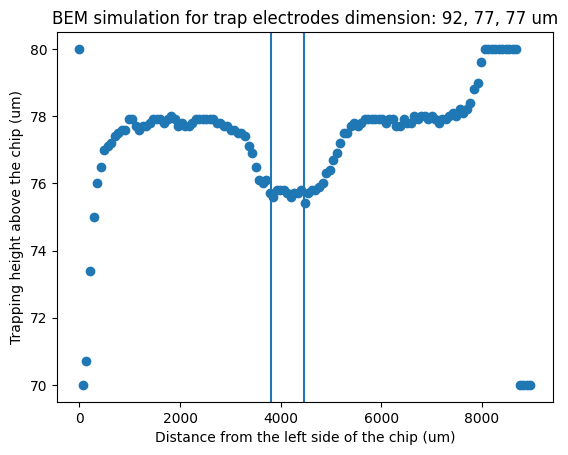

In [74]:
%matplotlib inline

plt.scatter((center_arr-center_begin)*a0*1e6, z0_arr);
plt.xlabel('Distance from the left side of the chip (um)');
plt.ylabel('Trapping height above the chip (um)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');
plt.axvline(3812);
plt.axvline(4470);

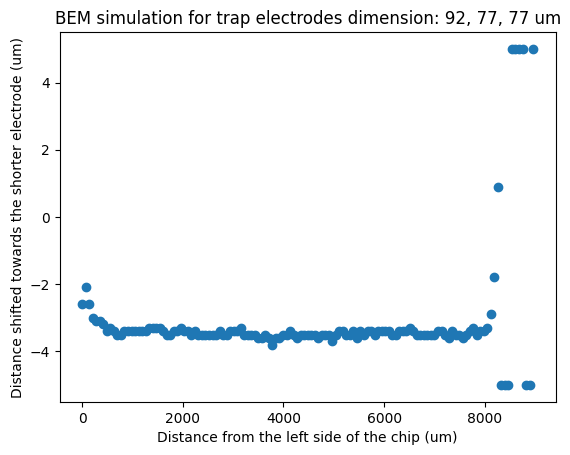

In [68]:
%matplotlib inline
plt.scatter((center_arr-center_begin)*a0*1e6, y0_arr);
plt.xlabel('Distance from the left side of the chip (um)');
plt.ylabel('Distance shifted towards the shorter electrode (um)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');

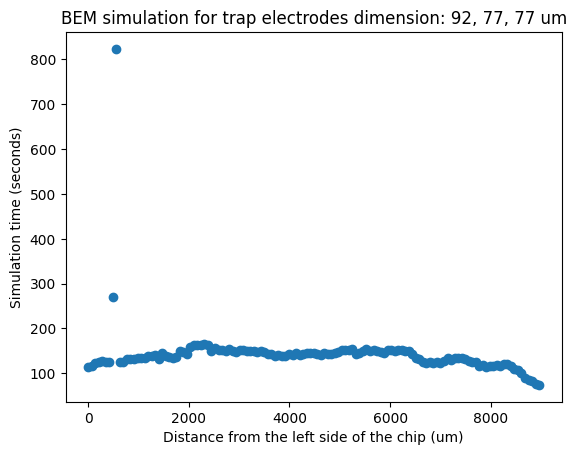

In [69]:
%matplotlib inline
plt.scatter((center_arr-center_begin)*a0*1e6, time_arr);
plt.xlabel('Distance from the left side of the chip (um)');
plt.ylabel('Simulation time (seconds)');
plt.title('BEM simulation for trap electrodes dimension: 92, 77, 77 um');

In [75]:
# save the data

import scipy.io

path = '/Users/yiyangzhi/Library/CloudStorage/GoogleDrive-yiyang_zhi3@berkeley.edu/My Drive/Ming Wu Integrated Photonics Group/Simulations/MATLAB/BEM_results/'
scipy.io.savemat(path + 'Ba_with_cutout.mat', {'Distance': center_arr , 'Height': z0_arr, 'Offset': y0_arr, 'time': time_arr});
